# Setup

## Imports

In [30]:
from vaiutils import path_consts, plot_images, channels_last
from tqdm import tqdm_notebook

In [28]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST

## Load data and variables

In [4]:
for k,v in path_consts('GAN','MNIST'):
    exec(k+'=v')

In [5]:
batch_size=64
transform=transforms.Compose([transforms.ToTensor()])
dataset = MNIST(DIR_DATA, transform=transform)
data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

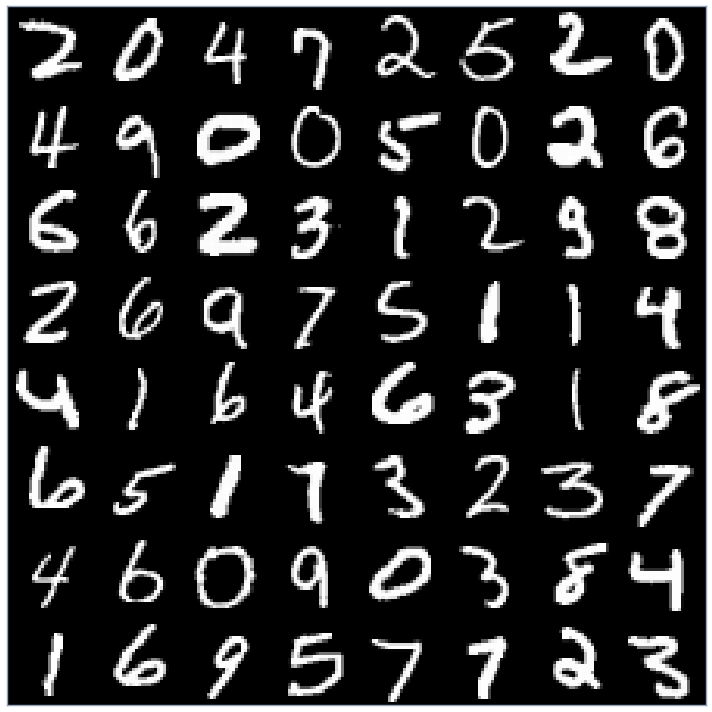

In [21]:
plot_images(channels_last(iter(data).next()[0].numpy()))

# Create Model

In [116]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1=nn.Linear(32,128)
        self.fc2=nn.Linear(128,1*28*28)
    def forward(self, z):
        z=F.relu(self.fc1(z))
        return F.sigmoid(self.fc2(z)).view(-1,1,28,28)

In [121]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1=nn.Linear(1*28*28,128)
        self.fc2=nn.Linear(128,1)
    def forward(self, x):
        x=F.relu(self.fc1(x.view(-1,1*28*28)))
        return F.sigmoid(self.fc2(x))

In [138]:
generator=Generator().cuda()
discriminator=Discriminator().cuda()

optimizer_g=optim.Adam(generator.parameters(),lr=1e-4)
optimizer_d=optim.Adam(discriminator.parameters(),lr=1e-4)

# Train Model

In [139]:
history={'loss_g':[],'loss_d':[]}

def optimize(epochs=1):
    for epoch in tqdm_notebook(range(epochs)):
        for batch, datum in enumerate(tqdm_notebook(data)):
            x_batch = Variable(datum[0].cuda())
            z_batch=Variable(torch.rand(x_batch.cpu().data.size()[0], 32).cuda())
            
            optimizer_d.zero_grad()
            x_gen=generator(z_batch)
            p_real=discriminator(x_batch)
            p_fake=discriminator(x_gen)
            
            loss_d=-(torch.log(p_real)+torch.log(1-p_fake)).mean()
            loss_g=-torch.log(p_fake).mean()
            loss_d.backward(retain_graph=True)
            optimizer_d.step()
            optimizer_g.zero_grad()
            loss_g.backward()
            optimizer_g.step()
            
            if batch%100==0:
                history['loss_d'].append(loss_d.cpu().data.numpy()[0])
                history['loss_g'].append(loss_g.cpu().data.numpy()[0])
            
            if batch==len(data)-1:
                plot_images(channels_last(x_gen[:5].cpu().data.numpy()))

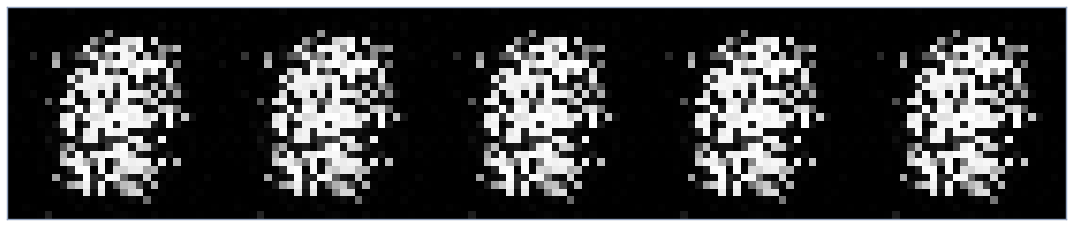

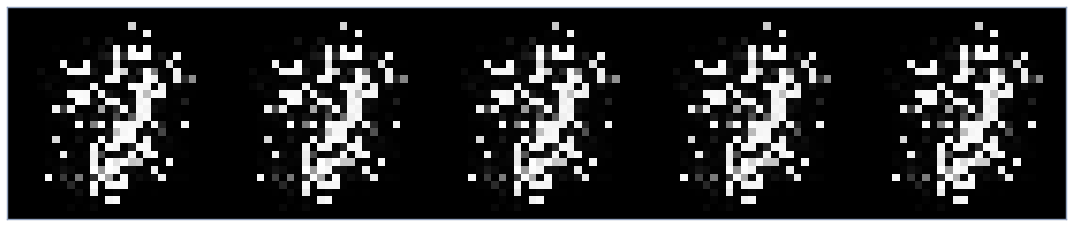

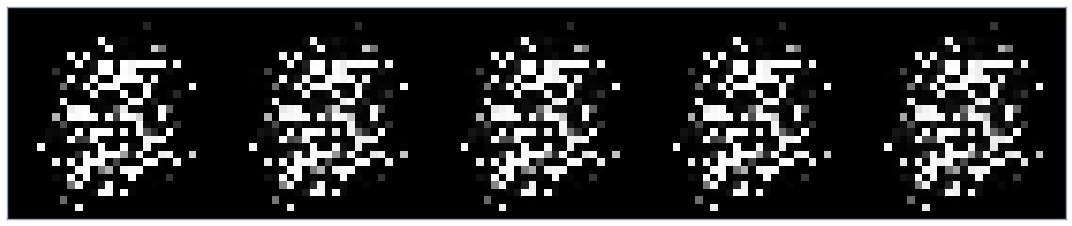

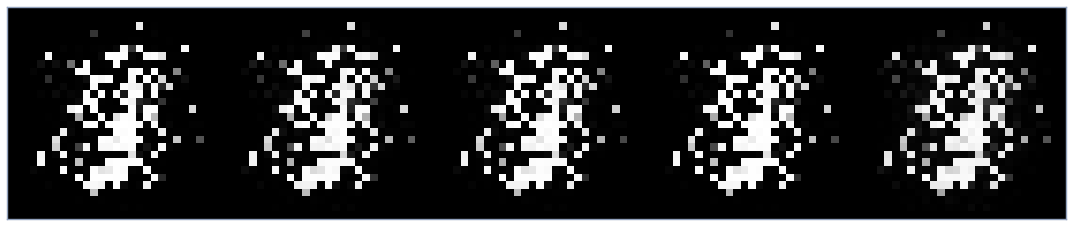

In [136]:
optimize(4)

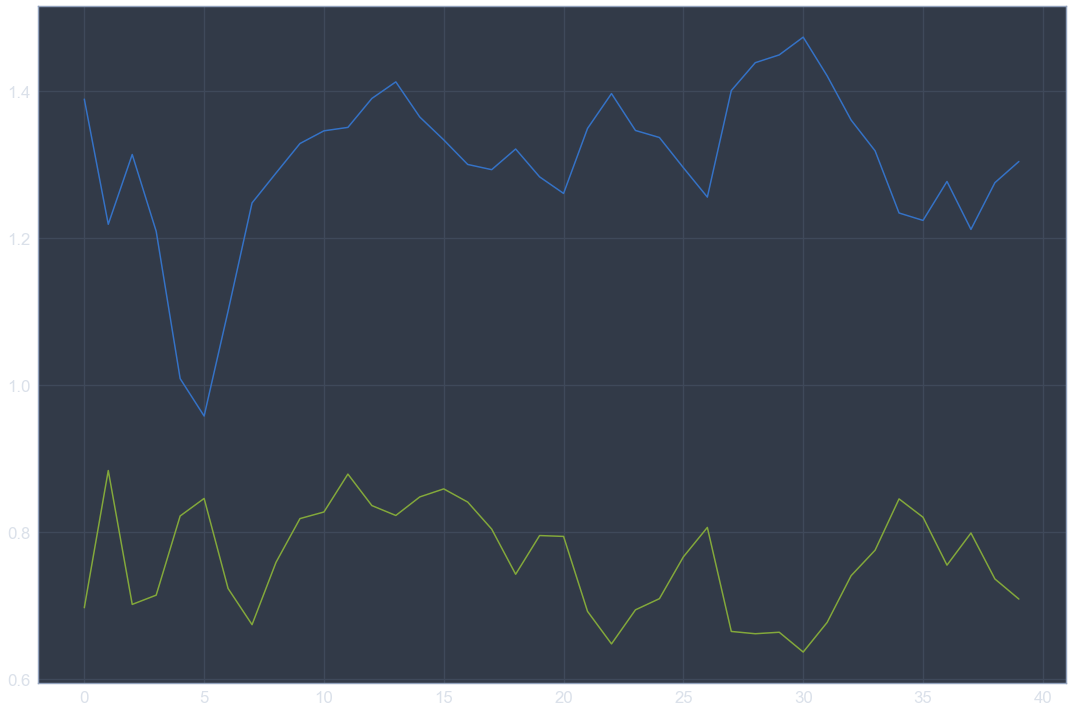

In [137]:
plot(history['loss_d'])
plot(history['loss_g'])